<a href="https://colab.research.google.com/github/mharisirfan/PROJ_ASD_ML/blob/Test%2Fasd-preview-grid/ML_ASD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive, and setting Folder path to DATA_DIR. You have to add shared Directory to your Drive by going to the folder in drive, and select "Add to shortcut and select MY Drive"


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DATA_DIR = "/content/drive/MyDrive/MTAT.03.227/"
REPO_URL = "https://github.com/mharisirfan/PROJ_ASD_ML.git"
BRANCH_NAME = "Test/asd-preview-grid"
YOUR_NAME = "Dev"
YOUR_EMAIL = "Haris"


Mounted at /content/drive


In [ ]:
PUSH_TO_GITHUB = True        # False = create files locally only
USE_TOKEN = False            # True = embed token in URL for this session
GITHUB_TOKEN = ""

Writing a text code to view 10 random images from ASD Data -> test -> autism and typical


Autism: 141 valid, 0 skipped (zero-byte/corrupt/zero-dim)
Tipical: 140 valid, 0 skipped (zero-byte/corrupt/zero-dim)


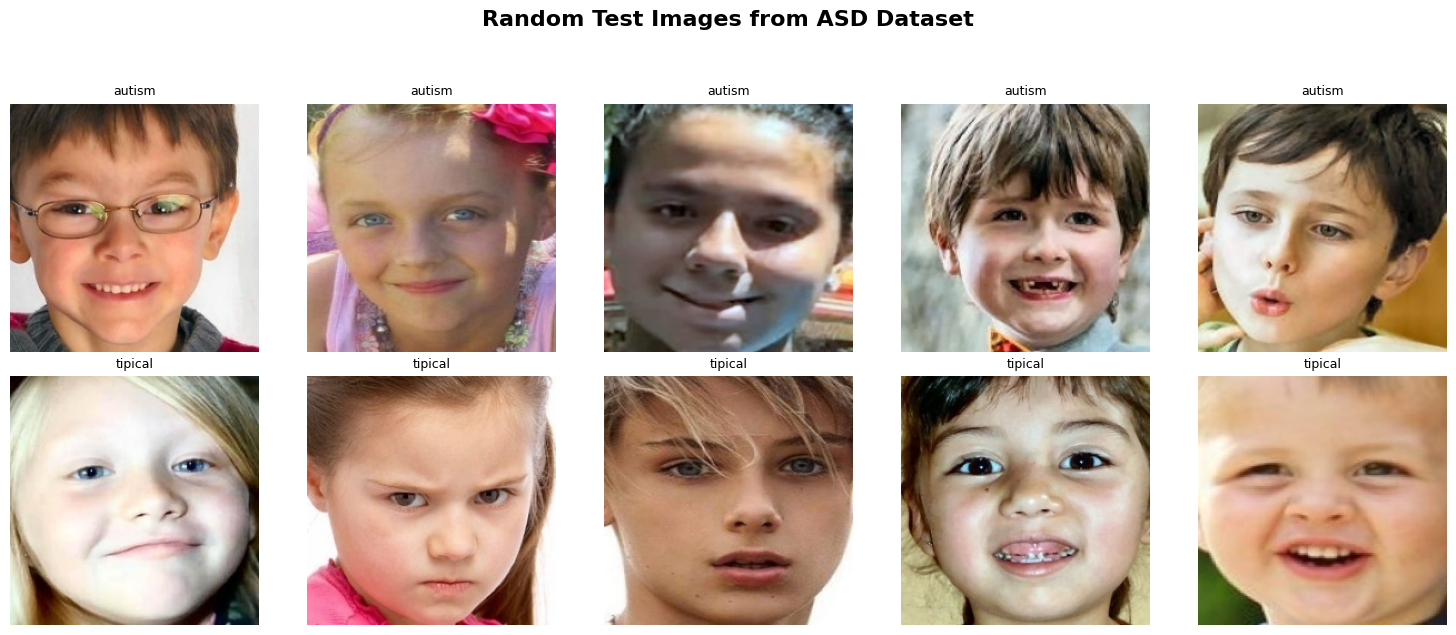

In [ ]:
import os, glob, random
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

AUTISM_DIR  = Path("/content/drive/MyDrive/MTAT.03.227/Kaggle/ASD Data/ASD Data/Test/autism")
TIPICAL_DIR = Path("/content/drive/MyDrive/MTAT.03.227/Kaggle/ASD Data/ASD Data/Test/tipical")
NUM = 5
random.seed(42)

EXTS = ("*.png","*.jpg","*.jpeg","*.bmp","*.webp","*.JPG","*.JPEG","*.PNG","*.BMP","*.WEBP")

def collect_files(d: Path):
    files = []
    for ext in EXTS:
        files += glob.glob(str(d / ext))
    # keep only >0 byte files
    return sorted({p for p in files if os.path.getsize(p) > 0})

def keep_valid(paths):
    valid, bad = [], []
    for p in paths:
        try:
            # quick integrity check without decoding full image
            with Image.open(p) as im:
                im.verify()
            # reopen to get size safely
            with Image.open(p) as im2:
                w, h = im2.size
            if w > 0 and h > 0:
                valid.append(p)
            else:
                bad.append(p)
        except (UnidentifiedImageError, OSError):
            bad.append(p)
    return valid, bad

autism_all  = collect_files(AUTISM_DIR)
tipical_all = collect_files(TIPICAL_DIR)

autism_valid, autism_bad   = keep_valid(autism_all)
tipical_valid, tipical_bad = keep_valid(tipical_all)

print(f"Autism: {len(autism_valid)} valid, {len(autism_bad)} skipped (zero-byte/corrupt/zero-dim)")
print(f"Tipical: {len(tipical_valid)} valid, {len(tipical_bad)} skipped (zero-byte/corrupt/zero-dim)")

assert len(autism_valid) >= NUM, f"Need ≥{NUM} valid images in {AUTISM_DIR}, found {len(autism_valid)}"
assert len(tipical_valid) >= NUM, f"Need ≥{NUM} valid images in {TIPICAL_DIR}, found {len(tipical_valid)}"

pick_autism  = random.sample(autism_valid, NUM)
pick_tipical = random.sample(tipical_valid, NUM)

# Plot 2 × NUM grid
fig = plt.figure(figsize=(3*NUM, 6))
for i, p in enumerate(pick_autism, start=1):
    ax = fig.add_subplot(2, NUM, i)
    ax.imshow(Image.open(p))
    ax.set_title("autism", fontsize=9); ax.axis("off")

for i, p in enumerate(pick_tipical, start=1+NUM):
    ax = fig.add_subplot(2, NUM, i)
    ax.imshow(Image.open(p))
    ax.set_title("tipical", fontsize=9); ax.axis("off")

plt.suptitle("Random Test Images from ASD Dataset", fontsize=16, weight="bold", y=1.05)
plt.tight_layout();
plt.show()


Now pushing to github


In [ ]:
# --- Robust SSH + push (no tokens) ---
import os, re, pathlib, subprocess, sys

REPO_URL    = REPO_URL.strip()
BRANCH_NAME = BRANCH_NAME.strip()
YOUR_NAME   = YOUR_NAME.strip()
YOUR_EMAIL  = YOUR_EMAIL.strip()

def run(cmd, cwd=None, check=True):
    print("$", cmd)
    p = subprocess.run(cmd, shell=True, text=True, cwd=cwd,
                       stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(p.stdout, end="")
    if p.stderr:
        print(p.stderr, end="")
    if check and p.returncode != 0:
        raise subprocess.CalledProcessError(p.returncode, cmd)
    return p

# 1) Ensure private key exists and perms are correct
key_path = os.path.expanduser("~/.ssh/id_ed25519")
ssh_dir  = os.path.expanduser("~/.ssh")
if not os.path.isfile(key_path):
    raise SystemExit("✖ Private key not found at ~/.ssh/id_ed25519. Paste your key there first.")
os.makedirs(ssh_dir, exist_ok=True)
os.chmod(ssh_dir, 0o700)
os.chmod(key_path, 0o600)

# 2) Trust GitHub and start ssh-agent in THIS process
run("ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts || true")
run("chmod 644 ~/.ssh/known_hosts || true")

out = subprocess.check_output(["ssh-agent", "-s"], text=True)
for line in out.splitlines():
    if "SSH_AUTH_SOCK=" in line:
        os.environ["SSH_AUTH_SOCK"] = line.split("SSH_AUTH_SOCK=")[1].split(";")[0]
    if "SSH_AGENT_PID=" in line:
        os.environ["SSH_AGENT_PID"] = line.split("SSH_AGENT_PID=")[1].split(";")[0]
run("ssh-add ~/.ssh/id_ed25519")

# Quick auth check (should say 'Hi <user>!' or 'successfully authenticated')
subprocess.run(["ssh", "-T", "git@github.com"], text=True)

# 3) Ensure SSH remote + local clone dir
repo_name = re.sub(r"\.git$", "", REPO_URL.rstrip("/").split("/")[-1])
REPO_DIR  = f"/content/{repo_name}"

if REPO_URL.startswith("https://github.com/"):
    owner_repo = REPO_URL.split("github.com/")[1].rstrip("/")
    if owner_repo.endswith(".git"): owner_repo = owner_repo[:-4]
    SSH_URL = f"git@github.com:{owner_repo}.git"
else:
    SSH_URL = REPO_URL  # already SSH

if not pathlib.Path(REPO_DIR).is_dir():
    run(f'git clone "{SSH_URL}" "{REPO_DIR}"')
else:
    cur = run("git remote get-url origin", cwd=REPO_DIR, check=False)
    cur_url = cur.stdout.strip()
    if cur_url.startswith("https://github.com/"):
        run(f'git remote set-url origin "{SSH_URL}"', cwd=REPO_DIR)

# 4) Set identity and make sure the branch exists locally
run(f'git config user.name "{YOUR_NAME}"', cwd=REPO_DIR)
run(f'git config user.email "{YOUR_EMAIL}"', cwd=REPO_DIR)

# Fetch remote refs so push has context
run("git fetch origin -v", cwd=REPO_DIR, check=False)

# Try to switch; if missing, create from origin/main if present, else from current HEAD
switched = run(f'git checkout "{BRANCH_NAME}"', cwd=REPO_DIR, check=False)
if switched.returncode != 0:
    # base on origin/main if it exists
    has_main = subprocess.run('git rev-parse --verify origin/main',
                              shell=True, cwd=REPO_DIR).returncode == 0
    base_ref = "origin/main" if has_main else ""
    run(f'git checkout -b "{BRANCH_NAME}" {base_ref}'.strip(), cwd=REPO_DIR)

# Ensure there is at least one commit on this branch (create README if truly empty)
head_commit = subprocess.run("git rev-parse --verify HEAD", shell=True, cwd=REPO_DIR)
if head_commit.returncode != 0:
    (pathlib.Path(REPO_DIR)/"README.md").write_text("# PROJ_ASD_ML\n", encoding="utf-8")
    run("git add README.md", cwd=REPO_DIR)
    run('git commit -m "init commit from Colab"', cwd=REPO_DIR)

# Stage anything new, commit if needed (ok if nothing to commit)
run("git add -A", cwd=REPO_DIR)
commit_try = run('git commit -m "update from Colab (deploy key)"', cwd=REPO_DIR, check=False)
if commit_try.returncode != 0:
    print("Nothing to commit (working tree clean).")

# 5) Push with verbose output (shows auth/remote errors clearly)
run(f'git push -u origin "{BRANCH_NAME}" -v', cwd=REPO_DIR)
print(f"✔ Pushed '{BRANCH_NAME}' to {SSH_URL}")


$ ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts || true
# github.com:22 SSH-2.0-85ba476
$ chmod 644 ~/.ssh/known_hosts || true
$ ssh-add ~/.ssh/id_ed25519
Identity added: /root/.ssh/id_ed25519 (PROJ_ASD_ML colab deploy key)
$ git remote get-url origin
git@github.com:mharisirfan/PROJ_ASD_ML.git
$ git config user.name "Dev"
$ git config user.email "Haris"
$ git fetch origin -v
From github.com:mharisirfan/PROJ_ASD_ML
 * [new branch]      main       -> origin/main
$ git checkout "Test/asd-preview-grid"
error: pathspec 'Test/asd-preview-grid' did not match any file(s) known to git
$ git checkout -b "Test/asd-preview-grid" origin/main
Branch 'Test/asd-preview-grid' set up to track remote branch 'main' from 'origin'.
Already on 'Test/asd-preview-grid'
$ git add -A
$ git commit -m "update from Colab (deploy key)"
On branch Test/asd-preview-grid
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Nothing to commit (working tree clean).
$ git push -u origin

Test commit 2